<a href="https://colab.research.google.com/github/ajenningsfrankston/Dynamic-Memory-Network-Plus-master/blob/master/clrp_pytorch_roberta_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses the model created in pretrain any model notebook.

1. Pretrain Roberta Model: https://www.kaggle.com/maunish/clrp-pytorch-roberta-pretrain
2. Finetune Roberta Model: this notebook, <br/>
   Finetune Roberta Model TPU: https://www.kaggle.com/maunish/clrp-pytorch-roberta-finetune-tpu
3. Inference Notebook: https://www.kaggle.com/maunish/clrp-pytorch-roberta-inference
4. Roberta + SVM: https://www.kaggle.com/maunish/clrp-roberta-svm

In [ ]:
!pip install accelerate

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
FINAL = False

In [ ]:
import os,shutil
from os import path

def move_files(source_dir,target_dir,show_dir=False):
  if not path.isdir(target_dir):
    os.makedirs(target_dir)
  #  
  file_names = os.listdir(source_dir)
  #
  for file_name in file_names:
    shutil.copy(os.path.join(source_dir, file_name), target_dir)
  #
  if show_dir:
    print(os.listdir(target_dir))
  
source_dir = '/content/gdrive/MyDrive/kaggle_datasets/commonlitreadability'
target_dir = '../input/commonlitreadabilityprize'

move_files(source_dir,target_dir,True)

source_dir = '/content/gdrive/MyDrive/kaggle_datasets/clrp_roberta_base'
target_dir = '../input/clrp-roberta-base/clrp_roberta_base'

move_files(source_dir,target_dir,True)




['test.csv', 'sample_submission.csv', 'train.csv']
['training_args.bin', 'vocab.json', 'pytorch_model.bin', 'special_tokens_map.json', 'config.json', 'tokenizer_config.json', 'merges.txt']


In [ ]:
!pip install transformers
!pip install colorama

import os
import gc
import sys
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from accelerate import Accelerator
from transformers import (AutoModel,AutoTokenizer,get_cosine_schedule_with_warmup,AutoConfig)

from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
y_ = Fore.YELLOW
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

In [ ]:
train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_data = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
sample = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')

num_bins = int(np.floor(1 + np.log2(len(train_data))))
train_data.loc[:,'bins'] = pd.cut(train_data['target'],bins=num_bins,labels=False)

bins = train_data.bins.to_numpy()
target = train_data.target.to_numpy()

def rmse_score(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [ ]:
config = {
    'lr': 2e-5,
    'wd':0.01,
    'batch_size':16,
    'valid_step':10,
    'max_len':256,
    'epochs':3,
    'nfolds':5,
    'seed':42,
    'model_path':'../input/clrp-roberta-base/clrp_roberta_base',
}

os.makedirs('models')
for i in range(config['nfolds']):
    os.makedirs(f'models/model{i}',exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])

train_data['Fold'] = -1
kfold = StratifiedKFold(n_splits=config['nfolds'],shuffle=True,random_state=config['seed'])
for k , (train_idx,valid_idx) in enumerate(kfold.split(X=train_data,y=bins)):
    train_data.loc[valid_idx,'Fold'] = k

In [ ]:
train_data.head()

,id,url_legal,license,excerpt,target,standard_error,bins,Fold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,7,0
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,7,2
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,6,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,5,2
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,8,1


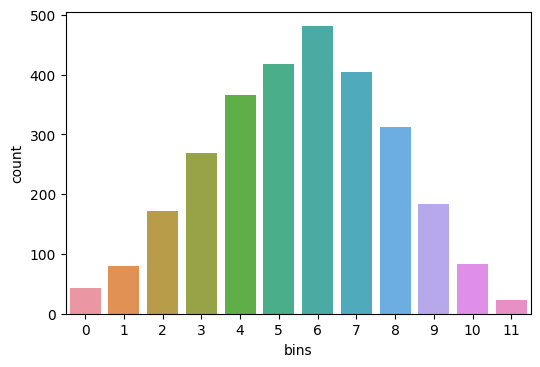

In [ ]:
plt.figure(dpi=100)
sns.countplot(train_data.bins);

In [ ]:
class CLRPDataset(Dataset):
    def __init__(self,df,tokenizer,max_len=128):
        self.excerpt = df['excerpt'].to_numpy()
        self.targets = df['target'].to_numpy()
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        
        target = torch.tensor(self.targets[idx],dtype=torch.float) 
        return encode, target
    
    def __len__(self):
        return len(self.excerpt)

In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim
        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

In [ ]:
class Model(nn.Module):
    def __init__(self,path):
        super(Model,self).__init__()
        roberta_config = AutoConfig.from_pretrained(path)
        roberta_config.update({"output_hidden_states":True, 
                       "hidden_dropout_prob": 0.0,
                       "layer_norm_eps": 1e-7})    
        self.roberta = AutoModel.from_pretrained(path,config=roberta_config)  
        self.head = AttentionHead(768,768,1)
        self.dropout = nn.Dropout(0.05) #original dropout 0.1
        self.linear = nn.Linear(768,1)
        self.attention = nn.Sequential(            
            nn.Linear(768, 512),            
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.regressor = nn.Sequential(                        
            nn.Linear(768, 1)                        
        )        

    def forward(self,**xb):
        x = self.roberta(**xb)
        last_layer_hidden_states = x.hidden_states[-1]
        weights = self.attention(last_layer_hidden_states)
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)  
        x = self.regressor(context_vector)
        return x

In [ ]:
def run(fold,verbose=True):
    
    def loss_fn(outputs,targets):
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        return torch.sqrt(nn.MSELoss()(outputs,targets))
    
    def train_and_evaluate_loop(train_loader,valid_loader,model,loss_fn,optimizer,epoch,fold,best_loss,valid_step=10,lr_scheduler=None):
        train_loss = 0
        for i, (inputs1,targets1) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            inputs1 = {key:val.reshape(val.shape[0],-1) for key,val in inputs1.items()}
            outputs1 = model(**inputs1)
            loss1 = loss_fn(outputs1,targets1)
            loss1.backward()
            optimizer.step()
            
            train_loss += loss1.item()
            
            if lr_scheduler:
                lr_scheduler.step()
            
            #evaluating for every valid_step
            if (i % valid_step == 0) or ((i + 1) == len(train_loader)):
                model.eval()
                valid_loss = 0
                with torch.no_grad():
                    for j, (inputs2,targets2) in enumerate(valid_loader):
                        inputs2 = {key:val.reshape(val.shape[0],-1) for key,val in inputs2.items()}
                        outputs2 = model(**inputs2)
                        loss2 = loss_fn(outputs2,targets2)
                        valid_loss += loss2.item()
                     
                    valid_loss /= len(valid_loader)
                    if valid_loss <= best_loss:
                        if verbose:
                            print(f"epoch:{epoch} | Train Loss:{train_loss/(i+1)} | Validation loss:{valid_loss}")
                            print(f"{g_}Validation loss Decreased from {best_loss} to {valid_loss}{sr_}")

                        best_loss = valid_loss
                        torch.save(model.state_dict(),f'./models/model{fold}/model{fold}.bin')
                        tokenizer.save_pretrained(f'./models/model{fold}')
                        
        return best_loss
    
    accelerator = Accelerator()
    print(f"{accelerator.device} is used")
    
    x_train,x_valid = train_data.query(f"Fold != {fold}"),train_data.query(f"Fold == {fold}")
    
    tokenizer = AutoTokenizer.from_pretrained(config['model_path'])
    model = Model(config['model_path'])

    train_ds = CLRPDataset(x_train,tokenizer,config['max_len'])
    train_dl = DataLoader(train_ds,
                        batch_size = config["batch_size"],
                        shuffle=True,
                        num_workers = 4,
                        pin_memory=True,
                        drop_last=False)

    valid_ds = CLRPDataset(x_valid,tokenizer,config['max_len'])
    valid_dl = DataLoader(valid_ds,
                        batch_size = config["batch_size"],
                        shuffle=False,
                        num_workers = 4,
                        pin_memory=True,
                        drop_last=False)

    optimizer = optim.AdamW(model.parameters(),lr=config['lr'],weight_decay=config['wd'])
    lr_scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps= 10 * len(train_dl))
    
    model,train_dl,valid_dl,optimizer,lr_scheduler = accelerator.prepare(model,train_dl,valid_dl,optimizer,lr_scheduler)

    print(f"Fold: {fold}")
    best_loss = 9999
    for epoch in range(config["epochs"]):
        print(f"Epoch Started:{epoch}")
        best_loss = train_and_evaluate_loop(train_dl,valid_dl,model,loss_fn,
                                            optimizer,epoch,fold,best_loss,
                                            valid_step=config['valid_step'],lr_scheduler=lr_scheduler)

In [ ]:
for f in range(config['nfolds']):
    run(f)

cuda is used


Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

Fold: 0
Epoch Started:0
epoch:0 | Train Loss:1.2959829568862915 | Validation loss:1.041612105237113
Validation loss Decreased from 9999 to 1.041612105237113
epoch:0 | Train Loss:0.9655827988277782 | Validation loss:0.8374442855517069
Validation loss Decreased from 1.041612105237113 to 0.8374442855517069
epoch:0 | Train Loss:0.8561332339332217 | Validation loss:0.683013379573822
Validation loss Decreased from 0.8374442855517069 to 0.683013379573822
epoch:0 | Train Loss:0.8076584262232627 | Validation loss:0.6569292801949713
Validation loss Decreased from 0.683013379573822 to 0.6569292801949713
epoch:0 | Train Loss:0.7806928339527874 | Validation loss:0.6187667457593812
Validation loss Decreased from 0.6569292801949713 to 0.6187667457593812
epoch:0 | Train Loss:0.7343597266019559 | Validation loss:0.5789426060186492
Validation loss Decreased from 0.6187667457593812 to 0.5789426060186492
epoch:0 | Train Loss:0.6957412895597057 | Validation loss:0.5538522717025545
Validation loss Decreased

Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

Fold: 1
Epoch Started:0
epoch:0 | Train Loss:1.9690983295440674 | Validation loss:1.3932412647538714
Validation loss Decreased from 9999 to 1.3932412647538714
epoch:0 | Train Loss:1.2246139428832314 | Validation loss:0.928462126188808
Validation loss Decreased from 1.3932412647538714 to 0.928462126188808
epoch:0 | Train Loss:1.0682000262396676 | Validation loss:0.7863156149784724
Validation loss Decreased from 0.928462126188808 to 0.7863156149784724
epoch:0 | Train Loss:0.8963409996614223 | Validation loss:0.7042519127329191
Validation loss Decreased from 0.7863156149784724 to 0.7042519127329191
epoch:0 | Train Loss:0.8509628480555964 | Validation loss:0.636020265519619
Validation loss Decreased from 0.7042519127329191 to 0.636020265519619
epoch:0 | Train Loss:0.809905567618667 | Validation loss:0.629437167611387
Validation loss Decreased from 0.636020265519619 to 0.629437167611387
epoch:0 | Train Loss:0.7628541916189059 | Validation loss:0.6200909829801984
Validation loss Decreased fr

Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

Fold: 2
Epoch Started:0
epoch:0 | Train Loss:1.7873579263687134 | Validation loss:1.3193097925848432
Validation loss Decreased from 9999 to 1.3193097925848432
epoch:0 | Train Loss:1.2299754673784429 | Validation loss:0.9252098633183373
Validation loss Decreased from 1.3193097925848432 to 0.9252098633183373
epoch:0 | Train Loss:1.0671595278240384 | Validation loss:0.7226783500777351
Validation loss Decreased from 0.9252098633183373 to 0.7226783500777351
epoch:0 | Train Loss:0.9660475773196067 | Validation loss:0.668947105606397
Validation loss Decreased from 0.7226783500777351 to 0.668947105606397
epoch:0 | Train Loss:0.8853727593654539 | Validation loss:0.6215295477045907
Validation loss Decreased from 0.668947105606397 to 0.6215295477045907
epoch:0 | Train Loss:0.8321613757049336 | Validation loss:0.600808795955446
Validation loss Decreased from 0.6215295477045907 to 0.600808795955446
epoch:0 | Train Loss:0.7929211600882108 | Validation loss:0.5606275490588613
Validation loss Decrease

Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

Fold: 3
Epoch Started:0
epoch:0 | Train Loss:1.1863605976104736 | Validation loss:1.0874077379703522
Validation loss Decreased from 9999 to 1.0874077379703522
epoch:0 | Train Loss:0.9819157502867959 | Validation loss:0.8918907327784432
Validation loss Decreased from 1.0874077379703522 to 0.8918907327784432
epoch:0 | Train Loss:0.8938601982025873 | Validation loss:0.735141760773129
Validation loss Decreased from 0.8918907327784432 to 0.735141760773129
epoch:0 | Train Loss:0.8430604944306035 | Validation loss:0.6274970968564352
Validation loss Decreased from 0.735141760773129 to 0.6274970968564352
epoch:0 | Train Loss:0.7986243810595536 | Validation loss:0.5809255788723627
Validation loss Decreased from 0.6274970968564352 to 0.5809255788723627
epoch:0 | Train Loss:0.695674944806982 | Validation loss:0.5364414362443818
Validation loss Decreased from 0.5809255788723627 to 0.5364414362443818
epoch:0 | Train Loss:0.6800645753577516 | Validation loss:0.5232159097989401
Validation loss Decreas

Some weights of the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN thi

Fold: 4
Epoch Started:0
epoch:0 | Train Loss:1.007411241531372 | Validation loss:1.0068308843506708
Validation loss Decreased from 9999 to 1.0068308843506708
epoch:0 | Train Loss:0.9340235482562672 | Validation loss:0.7945525439249145
Validation loss Decreased from 1.0068308843506708 to 0.7945525439249145
epoch:0 | Train Loss:0.8408319041842506 | Validation loss:0.6557311399115456
Validation loss Decreased from 0.7945525439249145 to 0.6557311399115456
epoch:0 | Train Loss:0.7870788151218046 | Validation loss:0.6077288786570231
Validation loss Decreased from 0.6557311399115456 to 0.6077288786570231
epoch:0 | Train Loss:0.7469255190070082 | Validation loss:0.580103274848726
Validation loss Decreased from 0.6077288786570231 to 0.580103274848726
epoch:0 | Train Loss:0.6913487153952239 | Validation loss:0.5700401970081859
Validation loss Decreased from 0.580103274848726 to 0.5700401970081859
epoch:0 | Train Loss:0.6662352643382381 | Validation loss:0.5656098855866326
Validation loss Decreas

In [ ]:
gdrive_model_dir = '/content/gdrive/MyDrive/kaggle_models/commonlitreadability'

if FINAL:
  shutil.make_archive(gdrive_model_dir + '/' + roberta_fine_tuned,'zip','./models')

